In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## MNIST dataset

In [3]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [4]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [5]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [6]:
input_size = 784
output_size = 10

In [7]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
#         print(idx)
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [8]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [9]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=1, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [10]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers, p=2):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.p = p
        
        self.centers = torch.randn(num_centers, input_dim)/3.
#         self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
    
    def forward(self, x):
        dists = torch.cdist(x, self.centers, p=self.p)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/dists.std(dim=1, keepdim=True)

        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass

## Umap pytorch GD

In [14]:
from scipy.optimize import curve_fit

In [108]:
# ## https://github.com/lmcinnes/umap/blob/master/umap/umap_.py

# class Umap(nn.Module):
    
#     def __init__(self, input_dim, output_dim, num_data, num_neighbour,
#                  min_dist=0.1, spread=1.0, negative_sample_rate=5):
#         super().__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.min_dist = min_dist
#         self.spread = spread
#         self.num_neighbour = num_neighbour
#         self.num_data = num_data
#         self.negative_sample_rate = negative_sample_rate
#         self.a, self.b = self.find_ab_params(spread, min_dist)
        
#         self.y_centers = nn.Parameter(torch.randn(num_data, output_dim)/3.)
#         self.criterion = nn.BCELoss()
        
#         self.sigma = None
#         pass
    
#     def compute_loss(self, x):
#         assert x.shape[0] < self.num_neighbour
#         dists = torch.cdist(x, x)+torch.eye(x.shape[0]).to(x.device)*1e5
#         _, indices = torch.topk(dists, k=self.num_neighbour, dim=1, largest=False, sorted=False)
# #         print(indices)
# #         print(indices.shape)
        
# #         neg_num = min(self.negative_sample_rate, x.shape[0]-self.num_neighbour)
#         neg_num = self.negative_sample_rate*self.num_neighbour
#         negative_indices = torch.randint(low=0, high=x.shape[0], size=(x.shape[0], neg_num)).to(indices.device)



# #         print(negative_indices.shape)
        
#         indices = torch.cat([indices, negative_indices], dim=1)
        
#         dists = torch.gather(dists, dim=1, index=indices)
# #         print(indices.shape)
        
# #         print(indices)
# #         return
        
#         dists = (dists-dists.min(dim=1, keepdim=True)[0])
# #                     /torch.sqrt(dists.var(dim=1, keepdim=True)+1e-5)
        
#         if self.sigma is None:
#             self.sigma = self.get_sigma(dists)
#         dists = dists/self.sigma
# #         print(dists_[0])
# #         print(indices[0])
# #         print(dists_[indices])
# #         print(dists_[indices].shape)
#         dists = torch.exp(-dists)
#         probX = torch.zeros(dists.shape[0], dists.shape[0]).to(x.device)
        
# #         print(indices.shape, probX.shape)
        
# #         probX[indices] = dists
#         probX.scatter_(dim=1, index=indices, src=dists)
# #         probX = 
# #         print(slc[0])
# #         print(slc.shape)

#         probX = probX+probX.t()-probX*probX.t()
    
    
#         dists = torch.cdist(self.y_centers, self.y_centers)

#         dists = torch.gather(dists, dim=1, index=indices)
#         probY = torch.zeros(dists.shape[0], dists.shape[0]).to(x.device)
#         probY.scatter_(dim=1, index=indices, src=dists)
# #         probY = dists

#         probY = 1/(1+self.a*(probY**(2*self.b)))
        
# #         loss = self.criterion(probX, probY)
#         loss = self._bceloss_(probX, probY)
        
#         return loss
    
#     def get_sigma(self, dists):
#         sigma = nn.Parameter(torch.std(dists.data, dim=1, keepdim=True)*0.2)
#         optim = torch.optim.Adam([sigma], lr=0.03)
#         target = torch.log2(torch.ones_like(sigma)*dists.shape[1]).to(dists.device)
#         for i in range(300):
#             delta = torch.sum(torch.exp(-dists/sigma), dim=1, keepdim=True)
#             delta = delta-target

#             optim.zero_grad()
#             error = (delta**2).sum()
#             error.backward()
#             optim.step()

#         return sigma.data
    
#     def _bceloss_(self, pX, pY):
#         logy = torch.clamp(torch.log(pY), min=-100)
#         log1_y = torch.clamp(torch.log(1-pY), min=-100)
# #         logy = torch.log(pY)
# #         log1_y = torch.log(1-pY)
#         return -torch.mean(pX*logy+(1-pX)*log1_y)
    
        
#     def find_ab_params(self, spread, min_dist):

#         def curve(x, a, b):
#             return 1.0 / (1.0 + a * x ** (2 * b))

#         xv = np.linspace(0, spread * 3, 300)
#         yv = np.zeros(xv.shape)
#         yv[xv < min_dist] = 1.0
#         yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist) / spread)
#         params, covar = curve_fit(curve, xv, yv)
#         return params[0], params[1]
        

In [262]:
## https://github.com/lmcinnes/umap/blob/master/umap/umap_.py

class Umap(nn.Module):
    
    def __init__(self, input_dim, output_dim, num_data, num_neighbour,
                 min_dist=0.1, spread=1.0, negative_sample_rate=5):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.min_dist = min_dist
        self.spread = spread
        self.num_neighbour = num_neighbour
        self.num_data = num_data
        self.negative_sample_rate = negative_sample_rate
        self.a, self.b = self.find_ab_params(spread, min_dist)
        
        self.y_centers = nn.Parameter(torch.randn(num_data, output_dim)/3.)
        self.criterion = nn.BCELoss()
        
        self.sigma = None
        self.cache = None
        pass
    
    def compute_loss(self, x):
        
            
        neg_num = min(self.negative_sample_rate, x.shape[0]-self.num_neighbour)
        neg_num = self.negative_sample_rate*self.num_neighbour

        
        if self.cache is None:
            assert x.shape[0] > self.num_neighbour
            dists = torch.cdist(x, x)+torch.eye(x.shape[0]).to(x.device)*1e5
            dists, indices = torch.topk(dists, k=self.num_neighbour, dim=1, largest=False, sorted=False)

            dists = (dists-dists.min(dim=1, keepdim=True)[0])
    #                     /torch.sqrt(dists.var(dim=1, keepdim=True)+1e-5)

            if self.sigma is None:
                self.sigma = self.get_sigma(dists)
            dists = dists/self.sigma
    #         print(dists_[0])
    #         print(indices[0])
    #         print(dists_[indices])
    #         print(dists_[indices].shape)
            dists = torch.exp(-dists)
            probX = torch.zeros(dists.shape[0], dists.shape[0]).to(x.device)

    #         print(indices.shape, probX.shape)

    #         probX[indices] = dists
            probX.scatter_(dim=1, index=indices, src=dists)
    #         probX = 
    #         print(slc[0])
    #         print(slc.shape)

            probX = probX+probX.t()-probX*probX.t()

    #         negative_indices = torch.randint(low=0, high=x.shape[0], size=(x.shape[0], neg_num)).to(indices.device)
    # #         _, negative_indices = torch.topk(dists, k=neg_num, dim=1, largest=True, sorted=False)

    #         indices = torch.cat([indices, negative_indices], dim=1)
    #         probX = torch.gather(prob, dim=1, index=indices)
    # #         print(indices.shape)

            zero_members = torch.zeros(dists.shape[0], neg_num, device=x.device)
            probX = torch.cat([probX, zero_members], dim=1)
            self.cache = (probX, indices)
        else:
            probX, indices = self.cache
#         print(probX.shape, neg_num)

    
#         probY = torch.zeros(dists.shape[0], dists.shape[0]).to(x.device)
        dists = torch.cdist(self.y_centers, self.y_centers)
        
        negative_indices = torch.randint(low=0, high=x.shape[0], size=(x.shape[0], neg_num)).to(indices.device)
        indices2 = torch.cat([indices, negative_indices], dim=1)
        
        dists = torch.gather(dists, dim=1, index=indices2)
        
        probY = torch.zeros_like(probX)
        probY.scatter_(dim=1, index=indices2, src=dists)
#         probY = dists

        probY = 1/(1+self.a*(probY**(2*self.b)))
        
#         loss = self.criterion(probX, probY)
        loss = self._bceloss_(probX, probY)
        
        return loss
    
    def get_sigma(self, dists):
        sigma = nn.Parameter(torch.std(dists.data, dim=1, keepdim=True)*0.2)
        optim = torch.optim.Adam([sigma], lr=0.03)
        target = torch.log2(torch.ones_like(sigma)*dists.shape[1]).to(dists.device)
        for i in range(300):
            delta = torch.sum(torch.exp(-dists/sigma), dim=1, keepdim=True)
            delta = delta-target

            optim.zero_grad()
            error = (delta**2).sum()
            error.backward()
            optim.step()

        return sigma.data
    
    def _bceloss_(self, pX, pY):
        logy = torch.clamp(torch.log(pY), min=-100)
        log1_y = torch.clamp(torch.log(1-pY), min=-100)
#         logy = torch.log(pY)
#         log1_y = torch.log(1-pY)
        return -torch.mean(pX*logy+(1-pX)*log1_y)
    
        
    def find_ab_params(self, spread, min_dist):

        def curve(x, a, b):
            return 1.0 / (1.0 + a * x ** (2 * b))

        xv = np.linspace(0, spread * 3, 300)
        yv = np.zeros(xv.shape)
        yv[xv < min_dist] = 1.0
        yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist) / spread)
        params, covar = curve_fit(curve, xv, yv)
        return params[0], params[1]
        

In [263]:
# torch.randn(784, 784)[torch.eye(784).type(torch.bool)]

In [303]:
ump = Umap(784, 2, num_data=784, num_neighbour=10, negative_sample_rate=5).to(device)

In [304]:
ump.a, ump.b

(1.576943460405378, 0.8950608781227859)

In [305]:
indices = np.random.permutation(len(train_loader.dataset.data))[:784]
xx, yy = train_loader.dataset[indices]
xx = xx.to(device)
xx.shape

torch.Size([784, 784])

In [307]:
ump.compute_loss(xx)

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)

In [450]:
optimizer = torch.optim.Adam(ump.parameters(), lr=0.25)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 0,  Loss:8.248151779174805


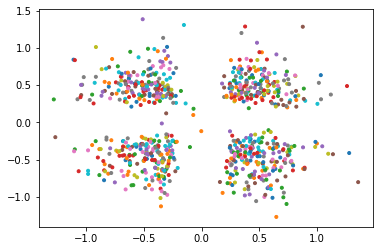

  1%|          | 95/10000 [00:00<01:08, 145.29it/s]

Epoch: 100,  Loss:1.308271050453186


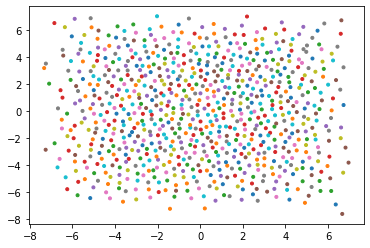

  2%|▏         | 186/10000 [00:01<01:08, 142.95it/s]

Epoch: 200,  Loss:1.2763564586639404


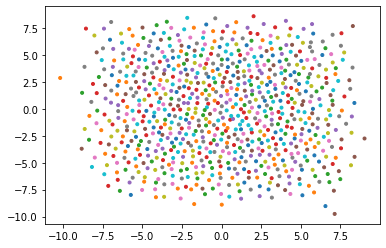

  3%|▎         | 291/10000 [00:02<01:07, 144.13it/s]

Epoch: 300,  Loss:1.2519261837005615


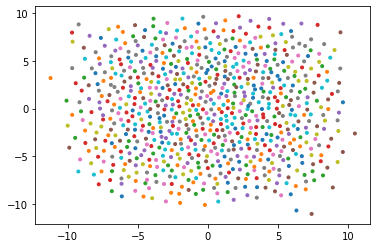

  4%|▍         | 396/10000 [00:02<01:06, 144.71it/s]

Epoch: 400,  Loss:1.2391102313995361


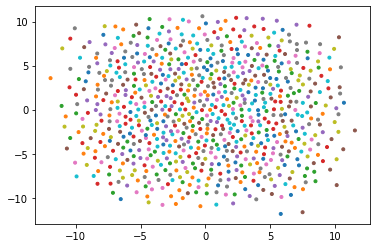

  5%|▍         | 489/10000 [00:03<01:05, 144.65it/s]

Epoch: 500,  Loss:1.2463840246200562


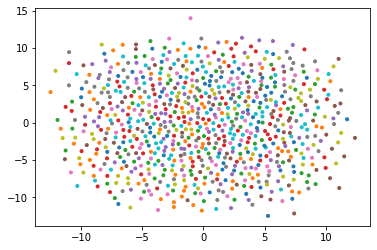

  6%|▌         | 600/10000 [00:04<01:08, 137.64it/s]

Epoch: 600,  Loss:1.2310187816619873


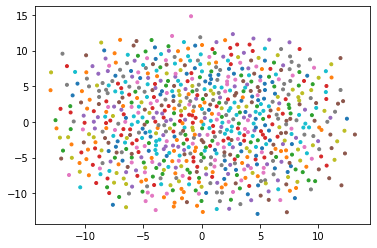

  7%|▋         | 695/10000 [00:05<01:04, 143.81it/s]

Epoch: 700,  Loss:1.2129945755004883


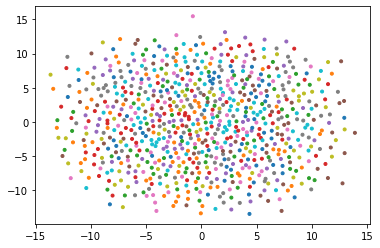

  8%|▊         | 789/10000 [00:06<01:03, 144.19it/s]

Epoch: 800,  Loss:1.1686224937438965


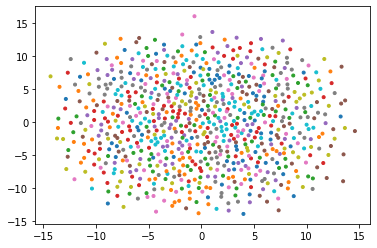

  9%|▉         | 897/10000 [00:06<01:02, 145.72it/s]

Epoch: 900,  Loss:1.177086353302002


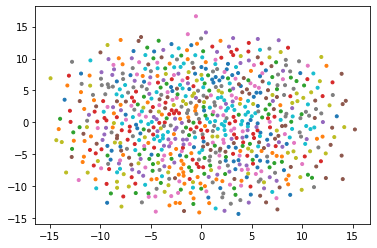

 10%|▉         | 991/10000 [00:07<01:02, 144.19it/s]

Epoch: 1000,  Loss:1.154050350189209


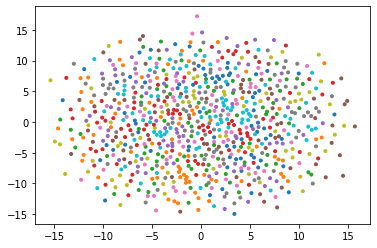

 11%|█         | 1086/10000 [00:08<01:01, 144.32it/s]

Epoch: 1100,  Loss:1.1612927913665771


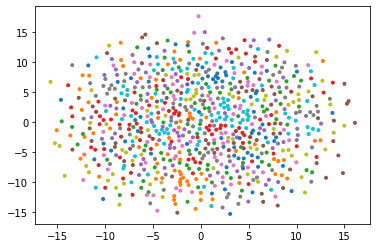

 12%|█▏        | 1195/10000 [00:09<01:00, 145.96it/s]

Epoch: 1200,  Loss:1.1714471578598022


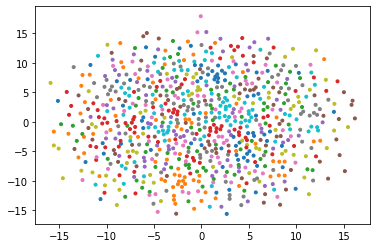

 13%|█▎        | 1289/10000 [00:09<01:00, 144.38it/s]

Epoch: 1300,  Loss:1.227820873260498


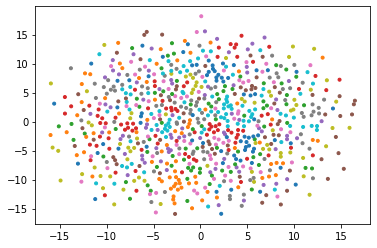

 14%|█▍        | 1397/10000 [00:10<00:59, 145.56it/s]

Epoch: 1400,  Loss:1.1680256128311157


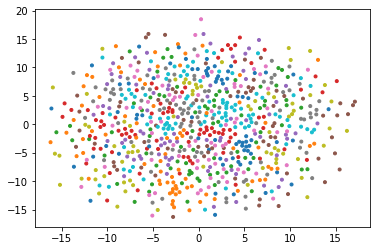

 15%|█▍        | 1492/10000 [00:11<00:58, 144.26it/s]

Epoch: 1500,  Loss:1.1501251459121704


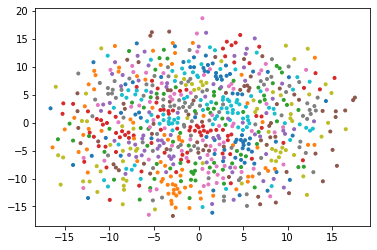

 16%|█▌        | 1587/10000 [00:12<00:58, 144.27it/s]

Epoch: 1600,  Loss:1.1321711540222168


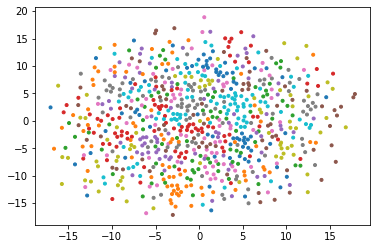

 17%|█▋        | 1698/10000 [00:12<00:56, 146.06it/s]

Epoch: 1700,  Loss:1.0995646715164185


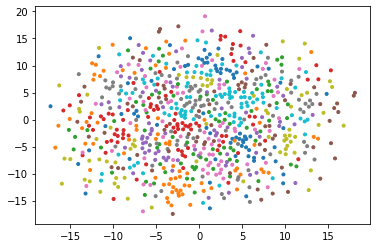

 18%|█▊        | 1793/10000 [00:13<00:56, 144.39it/s]

Epoch: 1800,  Loss:1.070468544960022


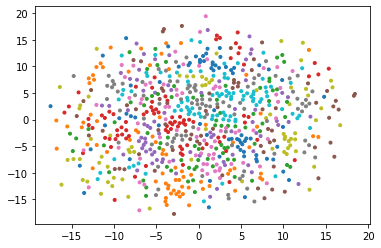

 19%|█▉        | 1888/10000 [00:14<00:56, 144.07it/s]

Epoch: 1900,  Loss:1.098254680633545


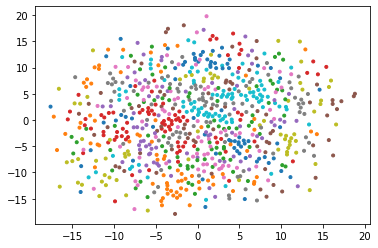

 20%|█▉        | 1998/10000 [00:15<00:54, 145.91it/s]

Epoch: 2000,  Loss:1.1727756261825562


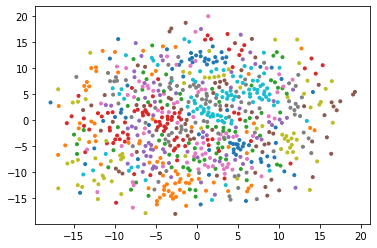

 21%|██        | 2093/10000 [00:15<00:54, 144.25it/s]

Epoch: 2100,  Loss:1.130009412765503


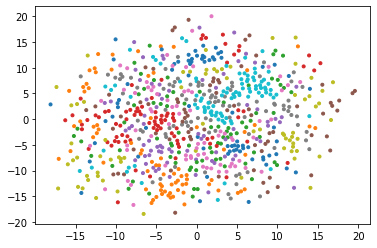

 22%|██▏       | 2188/10000 [00:16<00:54, 143.92it/s]

Epoch: 2200,  Loss:1.148066520690918


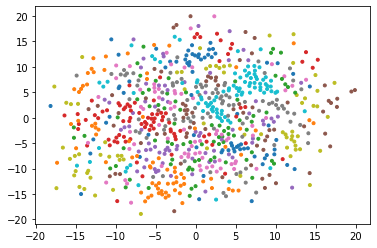

 23%|██▎       | 2299/10000 [00:17<00:52, 145.71it/s]

Epoch: 2300,  Loss:1.16363525390625


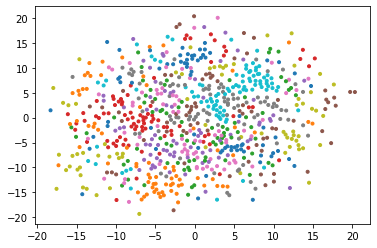

 24%|██▍       | 2394/10000 [00:18<00:52, 143.88it/s]

Epoch: 2400,  Loss:1.1155409812927246


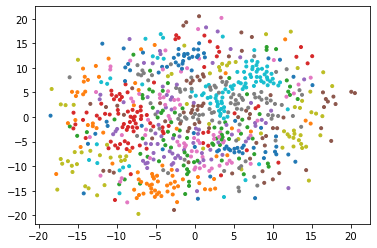

 25%|██▍       | 2487/10000 [00:18<00:52, 143.31it/s]

Epoch: 2500,  Loss:1.1100037097930908


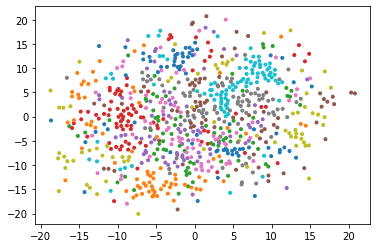

 26%|██▌       | 2596/10000 [00:19<00:51, 145.12it/s]

Epoch: 2600,  Loss:1.1020593643188477


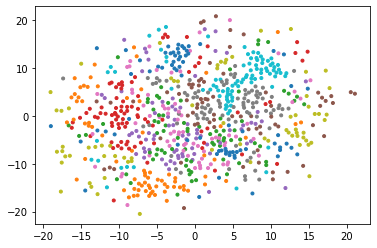

 27%|██▋       | 2690/10000 [00:20<00:50, 144.12it/s]

Epoch: 2700,  Loss:1.1053000688552856


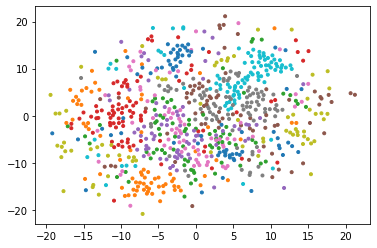

 28%|██▊       | 2785/10000 [00:20<00:50, 144.18it/s]

Epoch: 2800,  Loss:1.0682636499404907


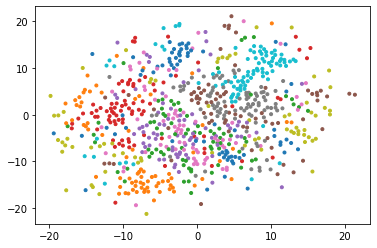

 29%|██▉       | 2894/10000 [00:21<00:48, 146.37it/s]

Epoch: 2900,  Loss:1.067745566368103


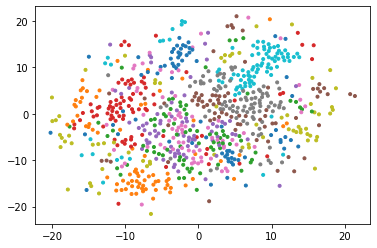

 30%|██▉       | 2989/10000 [00:22<00:48, 145.11it/s]

Epoch: 3000,  Loss:1.020139455795288


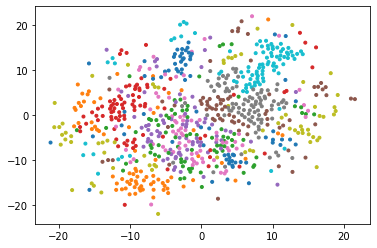

 31%|███       | 3100/10000 [00:23<00:47, 146.62it/s]

Epoch: 3100,  Loss:1.046815276145935


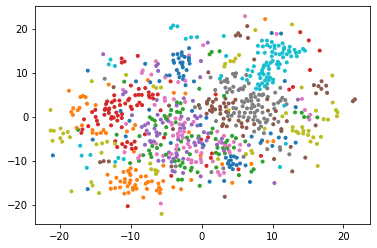

 32%|███▏      | 3195/10000 [00:23<00:46, 145.10it/s]

Epoch: 3200,  Loss:1.0674763917922974


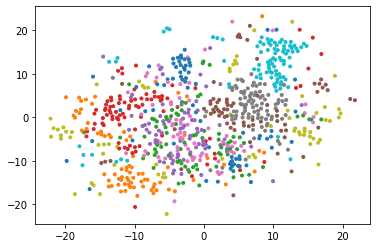

 33%|███▎      | 3288/10000 [00:24<00:46, 144.74it/s]

Epoch: 3300,  Loss:1.0913091897964478


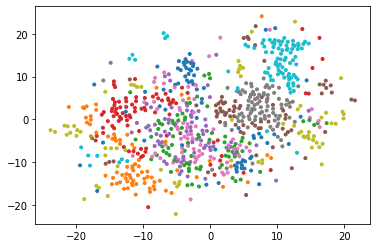

 34%|███▍      | 3399/10000 [00:25<00:45, 146.54it/s]

Epoch: 3400,  Loss:1.0413367748260498


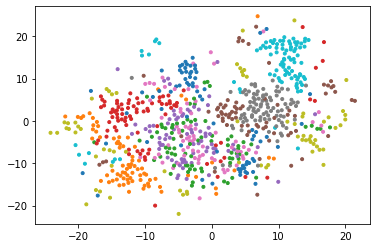

 35%|███▍      | 3494/10000 [00:26<00:44, 145.19it/s]

Epoch: 3500,  Loss:1.0519428253173828


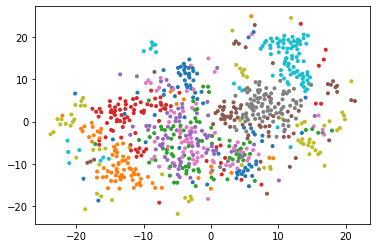

 36%|███▌      | 3587/10000 [00:26<00:44, 144.89it/s]

Epoch: 3600,  Loss:1.0146489143371582


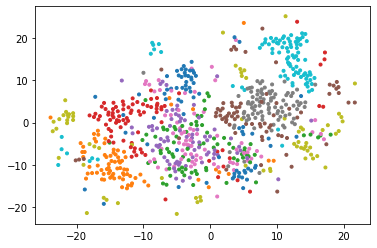

 37%|███▋      | 3696/10000 [00:27<00:43, 146.41it/s]

Epoch: 3700,  Loss:1.0641627311706543


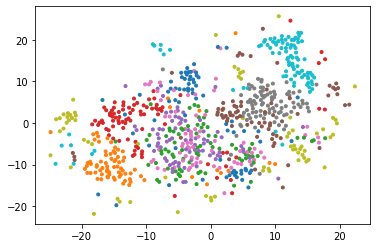

 38%|███▊      | 3790/10000 [00:28<00:42, 145.23it/s]

Epoch: 3800,  Loss:1.0035510063171387


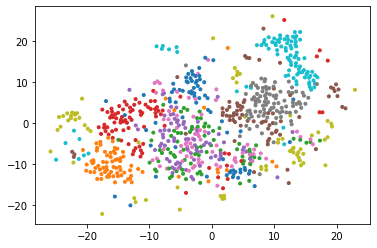

 39%|███▉      | 3885/10000 [00:29<00:42, 145.01it/s]

Epoch: 3900,  Loss:0.9845002889633179


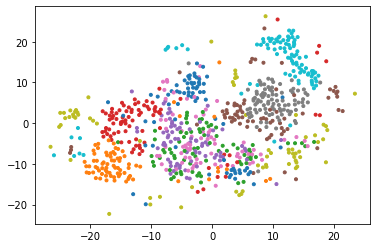

 40%|███▉      | 3995/10000 [00:29<00:40, 146.47it/s]

Epoch: 4000,  Loss:1.0104230642318726


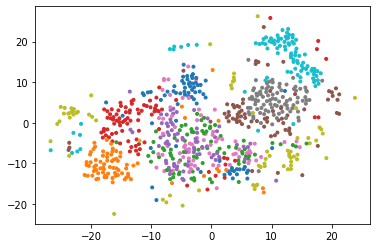

 41%|████      | 4086/10000 [00:30<00:40, 144.51it/s]

Epoch: 4100,  Loss:0.9552628993988037


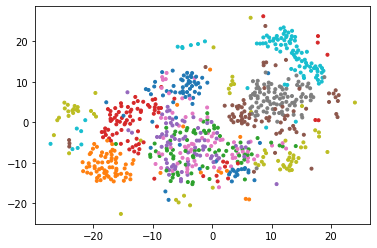

 42%|████▏     | 4196/10000 [00:31<00:39, 146.62it/s]

Epoch: 4200,  Loss:0.9791758060455322


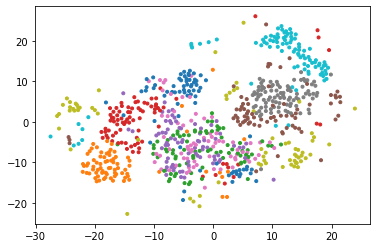

 43%|████▎     | 4290/10000 [00:32<00:39, 144.99it/s]

Epoch: 4300,  Loss:1.0272282361984253


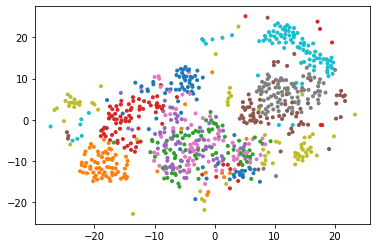

 44%|████▍     | 4385/10000 [00:32<00:38, 145.04it/s]

Epoch: 4400,  Loss:1.0438703298568726


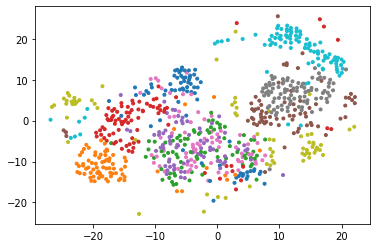

 45%|████▍     | 4496/10000 [00:33<00:37, 146.56it/s]

Epoch: 4500,  Loss:1.0032670497894287


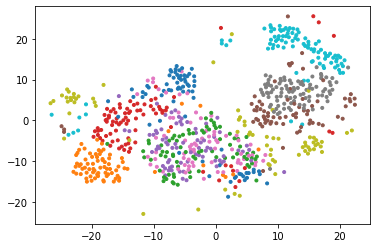

 46%|████▌     | 4591/10000 [00:34<00:37, 145.38it/s]

Epoch: 4600,  Loss:0.9716531038284302


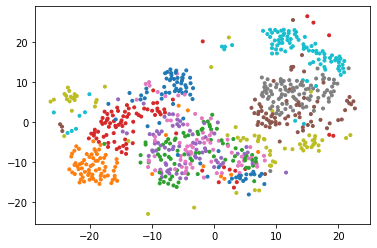

 47%|████▋     | 4686/10000 [00:34<00:36, 145.07it/s]

Epoch: 4700,  Loss:0.9971468448638916


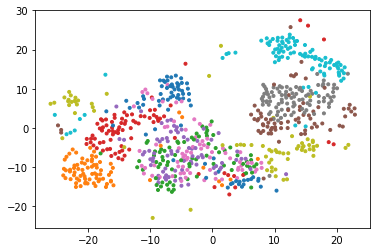

 48%|████▊     | 4796/10000 [00:35<00:35, 146.46it/s]

Epoch: 4800,  Loss:0.9987015724182129


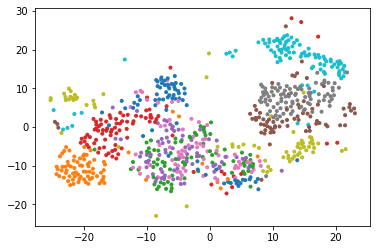

 49%|████▉     | 4891/10000 [00:36<00:35, 145.09it/s]

Epoch: 4900,  Loss:1.0043587684631348


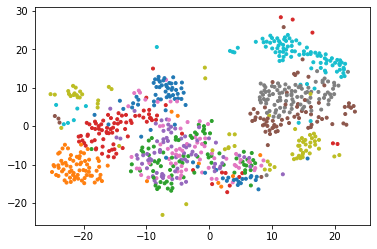

 50%|████▉     | 4986/10000 [00:37<00:34, 144.93it/s]

Epoch: 5000,  Loss:0.9860953092575073


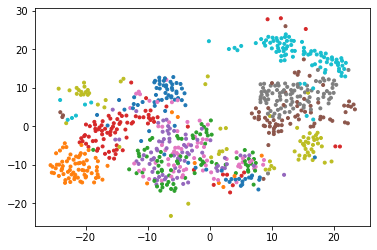

 51%|█████     | 5096/10000 [00:37<00:33, 146.55it/s]

Epoch: 5100,  Loss:1.0081840753555298


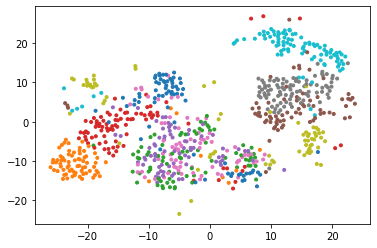

 52%|█████▏    | 5191/10000 [00:38<00:33, 145.02it/s]

Epoch: 5200,  Loss:1.0267513990402222


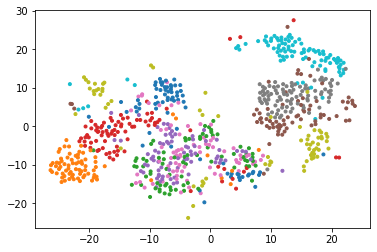

 53%|█████▎    | 5286/10000 [00:39<00:32, 144.89it/s]

Epoch: 5300,  Loss:1.02460777759552


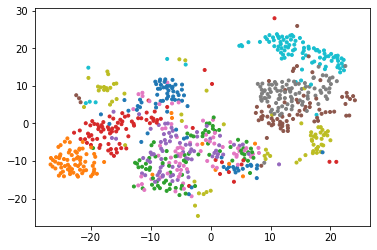

 54%|█████▍    | 5396/10000 [00:40<00:31, 146.43it/s]

Epoch: 5400,  Loss:0.9930447340011597


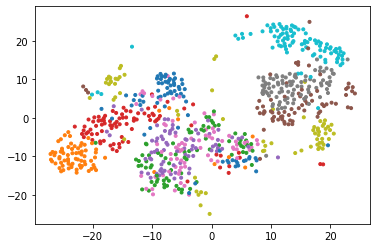

 55%|█████▍    | 5487/10000 [00:40<00:31, 144.88it/s]

Epoch: 5500,  Loss:0.9872915744781494


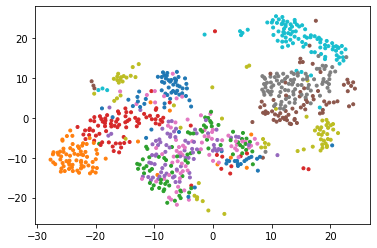

 56%|█████▌    | 5597/10000 [00:41<00:30, 146.51it/s]

Epoch: 5600,  Loss:0.9763100147247314


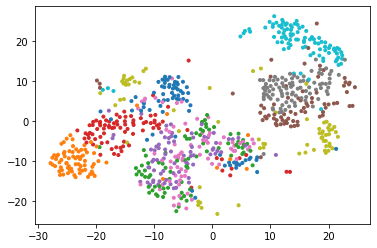

 57%|█████▋    | 5692/10000 [00:42<00:29, 145.23it/s]

Epoch: 5700,  Loss:1.0190565586090088


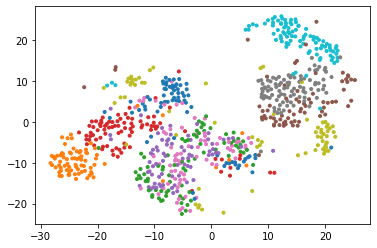

 58%|█████▊    | 5786/10000 [00:43<00:29, 145.13it/s]

Epoch: 5800,  Loss:0.9736683964729309


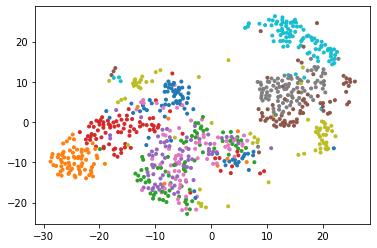

 59%|█████▉    | 5896/10000 [00:43<00:27, 146.61it/s]

Epoch: 5900,  Loss:1.0161558389663696


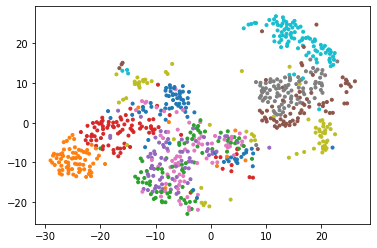

 60%|█████▉    | 5987/10000 [00:44<00:27, 144.49it/s]

Epoch: 6000,  Loss:0.9632378220558167


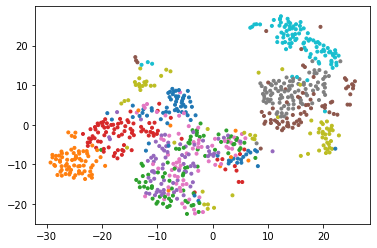

 61%|██████    | 6092/10000 [00:45<00:26, 145.79it/s]

Epoch: 6100,  Loss:1.0000579357147217


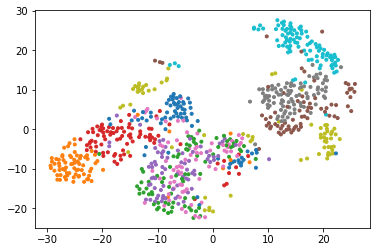

 62%|██████▏   | 6186/10000 [00:45<00:26, 144.80it/s]

Epoch: 6200,  Loss:0.9573805332183838


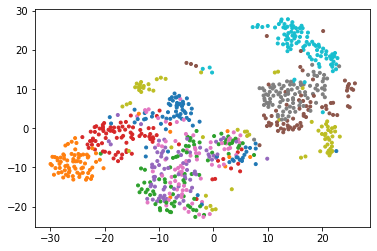

 63%|██████▎   | 6294/10000 [00:46<00:25, 146.16it/s]

Epoch: 6300,  Loss:0.941858172416687


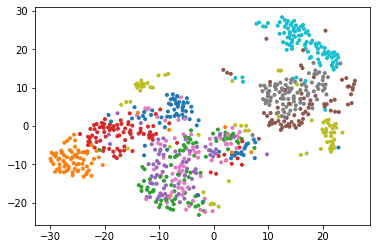

 64%|██████▍   | 6388/10000 [00:47<00:24, 144.66it/s]

Epoch: 6400,  Loss:1.0225882530212402


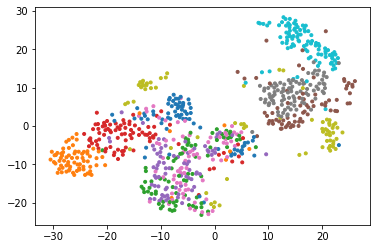

 65%|██████▍   | 6499/10000 [00:48<00:25, 137.68it/s]

Epoch: 6500,  Loss:0.9898699522018433


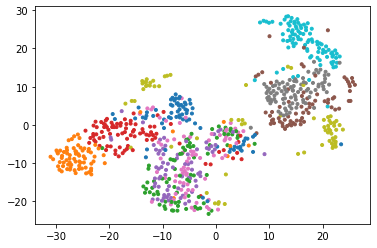

 66%|██████▌   | 6593/10000 [00:49<00:23, 143.79it/s]

Epoch: 6600,  Loss:0.9601929187774658


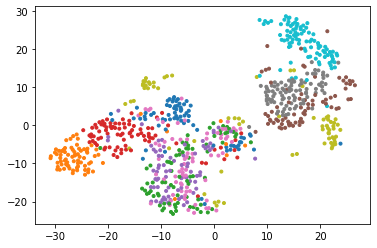

 67%|██████▋   | 6688/10000 [00:49<00:22, 144.60it/s]

Epoch: 6700,  Loss:0.9676882028579712


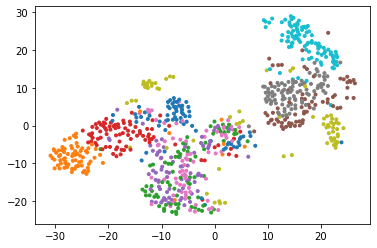

 68%|██████▊   | 6796/10000 [00:50<00:21, 145.83it/s]

Epoch: 6800,  Loss:0.9436307549476624


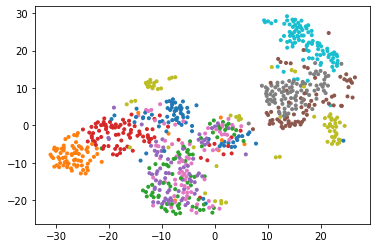

 69%|██████▉   | 6891/10000 [00:51<00:21, 144.77it/s]

Epoch: 6900,  Loss:0.98033607006073


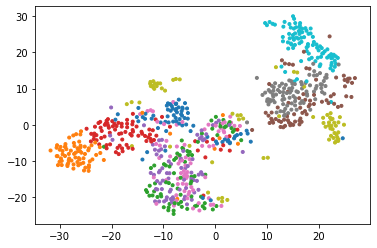

 70%|██████▉   | 6985/10000 [00:52<00:20, 144.62it/s]

Epoch: 7000,  Loss:0.9512643814086914


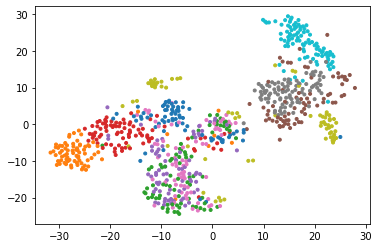

 71%|███████   | 7094/10000 [00:52<00:19, 145.87it/s]

Epoch: 7100,  Loss:1.0263738632202148


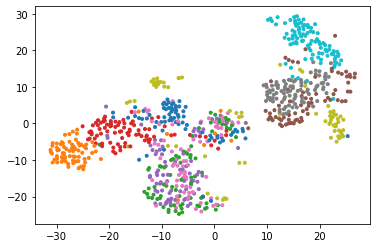

 72%|███████▏  | 7187/10000 [00:53<00:19, 144.53it/s]

Epoch: 7200,  Loss:1.0103193521499634


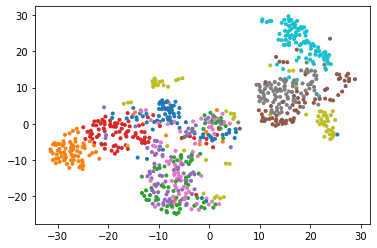

 73%|███████▎  | 7297/10000 [00:54<00:18, 146.00it/s]

Epoch: 7300,  Loss:0.9963316917419434


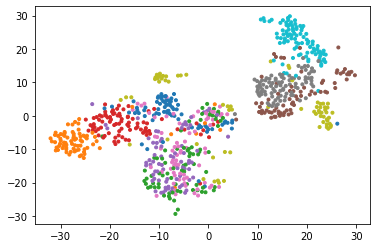

 74%|███████▍  | 7391/10000 [00:55<00:18, 144.45it/s]

Epoch: 7400,  Loss:0.9947013854980469


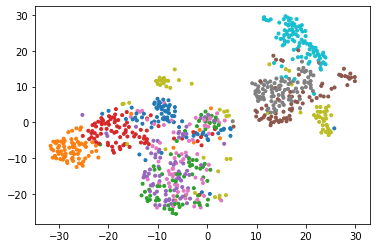

 75%|███████▍  | 7486/10000 [00:55<00:17, 144.51it/s]

Epoch: 7500,  Loss:1.0645391941070557


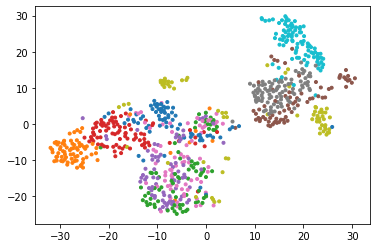

 76%|███████▌  | 7596/10000 [00:56<00:16, 146.17it/s]

Epoch: 7600,  Loss:0.9841492772102356


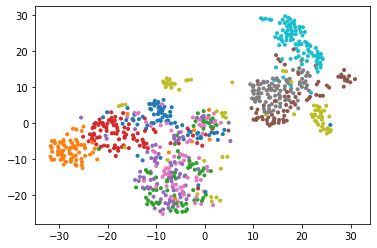

 77%|███████▋  | 7691/10000 [00:57<00:15, 144.76it/s]

Epoch: 7700,  Loss:0.9955857992172241


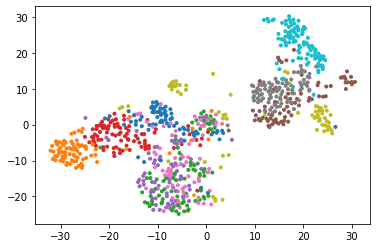

 78%|███████▊  | 7785/10000 [00:57<00:15, 144.51it/s]

Epoch: 7800,  Loss:0.9376372694969177


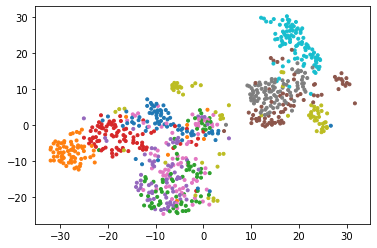

 79%|███████▉  | 7894/10000 [00:58<00:14, 145.82it/s]

Epoch: 7900,  Loss:0.9919782876968384


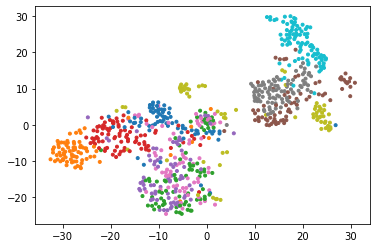

 80%|███████▉  | 7989/10000 [00:59<00:13, 144.70it/s]

Epoch: 8000,  Loss:0.9510972499847412


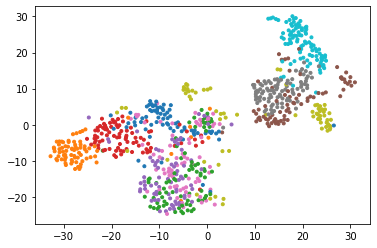

 81%|████████  | 8100/10000 [01:00<00:12, 146.72it/s]

Epoch: 8100,  Loss:0.9503039121627808


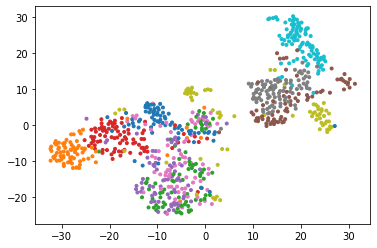

 82%|████████▏ | 8195/10000 [01:00<00:12, 145.28it/s]

Epoch: 8200,  Loss:0.9972633719444275


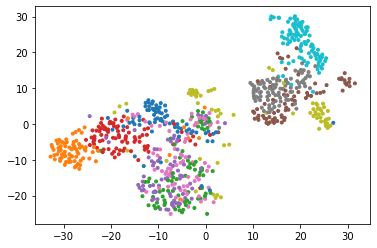

 83%|████████▎ | 8290/10000 [01:01<00:11, 144.85it/s]

Epoch: 8300,  Loss:0.9599292278289795


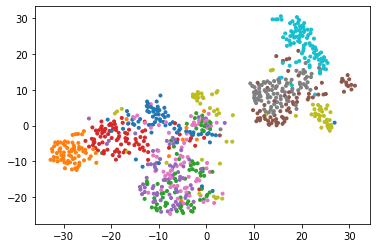

 84%|████████▍ | 8385/10000 [01:02<00:11, 144.88it/s]

Epoch: 8400,  Loss:0.9697223901748657


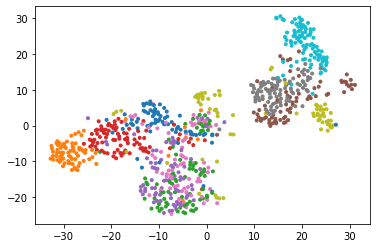

 85%|████████▍ | 8496/10000 [01:03<00:10, 146.63it/s]

Epoch: 8500,  Loss:0.9972591400146484


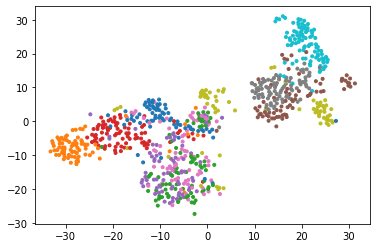

 86%|████████▌ | 8591/10000 [01:03<00:09, 144.93it/s]

Epoch: 8600,  Loss:0.9593499898910522


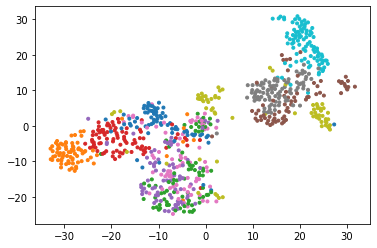

 87%|████████▋ | 8686/10000 [01:04<00:09, 144.85it/s]

Epoch: 8700,  Loss:0.9723981618881226


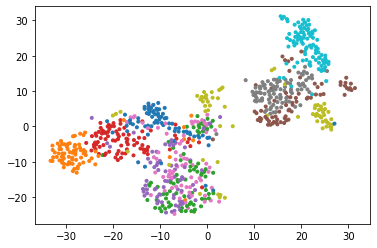

 88%|████████▊ | 8796/10000 [01:05<00:08, 146.69it/s]

Epoch: 8800,  Loss:0.956999659538269


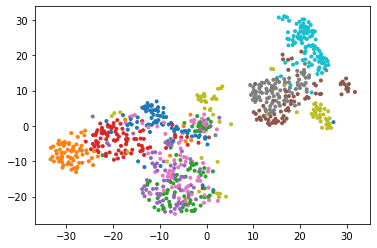

 89%|████████▉ | 8891/10000 [01:06<00:07, 145.25it/s]

Epoch: 8900,  Loss:0.9484964609146118


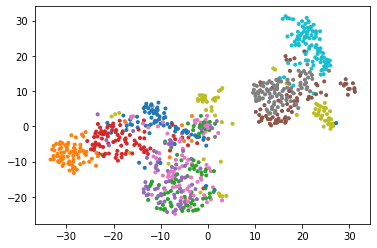

 90%|████████▉ | 8986/10000 [01:06<00:06, 144.95it/s]

Epoch: 9000,  Loss:0.9584015607833862


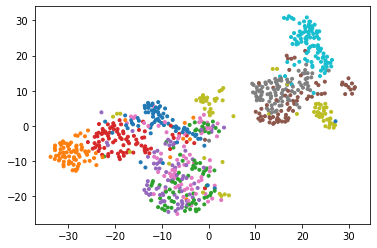

 91%|█████████ | 9096/10000 [01:07<00:06, 146.68it/s]

Epoch: 9100,  Loss:0.9425057172775269


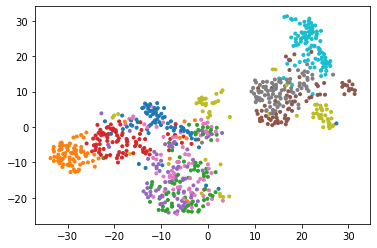

 92%|█████████▏| 9191/10000 [01:08<00:05, 145.35it/s]

Epoch: 9200,  Loss:1.0095727443695068


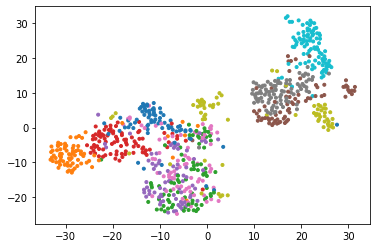

 93%|█████████▎| 9286/10000 [01:09<00:04, 145.05it/s]

Epoch: 9300,  Loss:0.9792650938034058


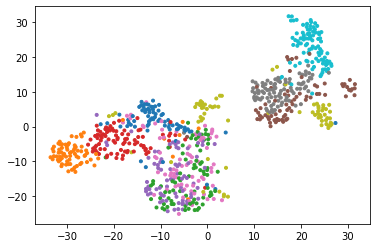

 94%|█████████▍| 9397/10000 [01:09<00:04, 146.76it/s]

Epoch: 9400,  Loss:0.9552267789840698


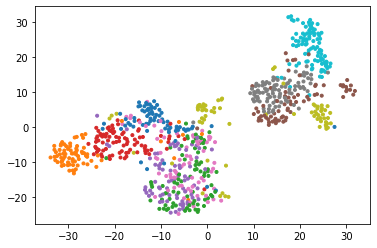

 95%|█████████▍| 9492/10000 [01:10<00:03, 145.17it/s]

Epoch: 9500,  Loss:0.9319416284561157


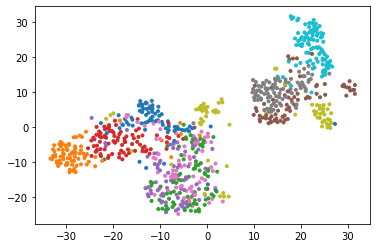

 96%|█████████▌| 9587/10000 [01:11<00:02, 145.34it/s]

Epoch: 9600,  Loss:0.960372805595398


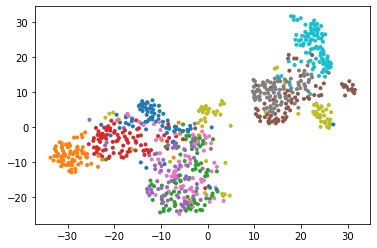

 97%|█████████▋| 9698/10000 [01:12<00:02, 147.04it/s]

Epoch: 9700,  Loss:0.9570240378379822


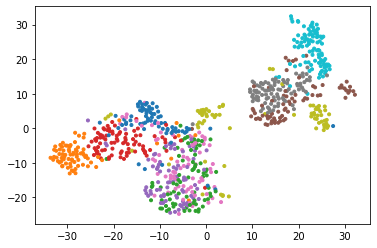

 98%|█████████▊| 9793/10000 [01:12<00:01, 145.45it/s]

Epoch: 9800,  Loss:0.9991017580032349


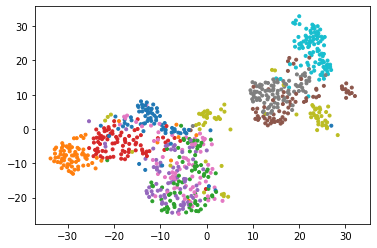

 99%|█████████▉| 9888/10000 [01:13<00:00, 145.29it/s]

Epoch: 9900,  Loss:0.9645445346832275


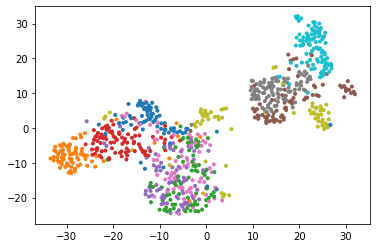

100%|██████████| 10000/10000 [01:14<00:00, 134.66it/s]


In [451]:
#### Train with Optimizer

train_error = []
for epoch in tqdm(list(range(10000))):
    loss = ump.compute_loss(xx)
    optimizer.zero_grad()
    loss.backward()
    
#     print(ump.y_centers.grad)
#     print(torch.count_nonzero(torch.isnan(ump.y_centers.grad)))
#     print(torch.count_nonzero(torch.isinf(ump.y_centers.grad)))
    ump.y_centers.grad[torch.isnan(ump.y_centers.grad)] = 0
    
    optimizer.step()
    stdm = ump.y_centers.data.std()
#     ump.y_centers.data = ump.y_centers.data + \
#                 (torch.rand_like(ump.y_centers.data)-0.5)*0.01*float(stdm)

    train_error.append(float(loss))
    
    if epoch%100 == 0:
#         print(ump.y_centers.data.std())
        print(f'Epoch: {epoch},  Loss:{float(loss)}')
        plt.scatter(*ump.y_centers.cpu().data.numpy().T, c=yy, marker='.', cmap="tab10")
        plt.show()
#     break

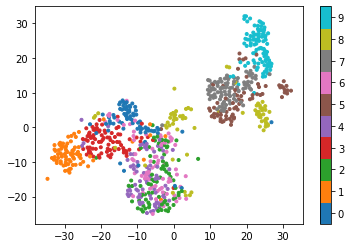

In [452]:
plt.scatter(*ump.y_centers.cpu().data.numpy().T, c=yy, marker='.', cmap="tab10")
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

## UMAP - from library

In [453]:
import umap

In [454]:
embed = umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.1, spread=1, metric="euclidean", negative_sample_rate=5)
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [455]:
embedding = embed.fit_transform(xx.data.cpu().numpy())
# embedding = embed.fit_transform(centers, output_cent)

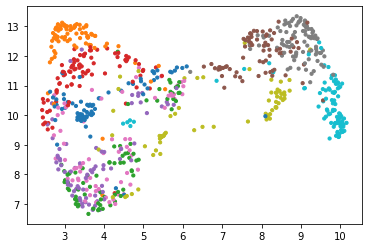

In [456]:
plt.scatter(embedding[:,0], embedding[:, 1], c=yy, s=10, cmap="tab10")

In [446]:
j = 0

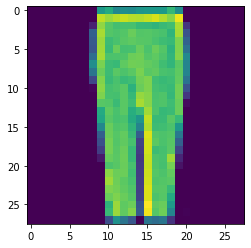

In [448]:
plt.imshow(xx.cpu()[j].reshape(28,28))
j += 1

### Umap-pytorch New Implementation

In [447]:
## https://github.com/lmcinnes/umap/blob/master/umap/umap_.py

class Umap(nn.Module):
    
    def __init__(self, input_dim, output_dim, num_data, num_neighbour,
                 min_dist=0.1, spread=1.0, negative_sample_rate=5):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.min_dist = min_dist
        self.spread = spread
        self.num_neighbour = num_neighbour
        self.num_data = num_data
        self.negative_sample_rate = negative_sample_rate
        self.a, self.b = self.find_ab_params(spread, min_dist)
        
        self.y_centers = nn.Parameter(torch.randn(num_data, output_dim)/3.)
        self.criterion = nn.BCELoss()
        
        self.sigma = None
        self.cache = None
        pass
    
    def compute_loss(self, x):
        
            
#         neg_num = min(self.negative_sample_rate, x.shape[0]-self.num_neighbour)
        neg_num = self.negative_sample_rate*self.num_neighbour

        
        if self.cache is None:
            assert x.shape[0] > self.num_neighbour
            
            ### positive sampling only
            dists = torch.cdist(x, x)+torch.eye(x.shape[0]).to(x.device)*1e5
            dists, indices = torch.topk(dists, k=self.num_neighbour, dim=1, largest=False, sorted=False)

            dists = (dists-dists.min(dim=1, keepdim=True)[0])
    #                     /torch.sqrt(dists.var(dim=1, keepdim=True)+1e-5)

            if self.sigma is None:
                self.sigma = self.get_sigma(dists)
            dists = dists/self.sigma
            dists = torch.exp(-dists)
            
            probX = torch.zeros(dists.shape[0], dists.shape[0]).to(x.device)
            probX.scatter_(dim=1, index=indices, src=dists)
            probX = probX+probX.t()-probX*probX.t()
#             probX = torch.gather(probX, dim=1, index=indices)
            
#             print(probX.shape)

            self.cache = (probX, indices)
        else:
            probX, indices = self.cache
#         print(probX.shape, neg_num)
        
        ## randomly sample from the probX, some points in same class are left alone
#         rand_indices = torch.randint(low=0, high=x.shape[0], size=(x.shape[0], self.num_neighbour//4)).to(indices.device)
#         indices = torch.cat([indices, rand_indices], dim=1)
        probX = torch.gather(probX, dim=1, index=indices)

    
#         probY = torch.zeros(dists.shape[0], dists.shape[0]).to(x.device)
        dists = torch.cdist(self.y_centers, self.y_centers)
        
#         negative_indices = torch.randint(low=0, high=x.shape[0], size=(x.shape[0], neg_num)).to(indices.device)
#         indices2 = torch.cat([indices, negative_indices], dim=1)
        
        probY = torch.gather(dists, dim=1, index=indices)
        probY = 1/(1+self.a*(probY**(2*self.b)))
#         print(probY.shape)

#         loss = self.criterion(probX, probY)
        loss_positive = self._bceloss_(probX, probY)
        
        probX = torch.zeros(x.shape[0], neg_num, device=x.device)
        negative_indices = torch.randint(low=0, high=x.shape[0], size=(x.shape[0], neg_num)).to(indices.device)
        probY = torch.gather(dists, dim=1, index=negative_indices)
        probY = 1/(1+self.a*(probY**(2*self.b)))
        
        loss_negative = self._bceloss_(probX, probY)
        
        ### if mean is used
        loss = loss_positive+loss_negative*self.negative_sample_rate
        ### if sum is used
#         loss = (loss_positive+loss_negative)*1/(x.shape[0]*self.num_neighbour)
    
    
        return loss
    
    def get_sigma(self, dists):
        sigma = nn.Parameter(torch.std(dists.data, dim=1, keepdim=True)*0.2)
        optim = torch.optim.Adam([sigma], lr=0.03)
        target = torch.log2(torch.ones_like(sigma)*dists.shape[1]).to(dists.device)
        for i in range(300):
            delta = torch.sum(torch.exp(-dists/sigma), dim=1, keepdim=True)
            delta = delta-target

            optim.zero_grad()
            error = (delta**2).sum()
            error.backward()
            optim.step()

        return sigma.data
    
    def _bceloss_(self, pX, pY):
        logy = torch.clamp(torch.log(pY), min=-100)
        log1_y = torch.clamp(torch.log(1-pY), min=-100)
#         logy = torch.log(pY)
#         log1_y = torch.log(1-pY)
        return -torch.mean(pX*logy+(1-pX)*log1_y)
#         return -torch.sum(pX*logy+(1-pX)*log1_y)

    
        
    def find_ab_params(self, spread, min_dist):

        def curve(x, a, b):
            return 1.0 / (1.0 + a * x ** (2 * b))

        xv = np.linspace(0, spread * 3, 300)
        yv = np.zeros(xv.shape)
        yv[xv < min_dist] = 1.0
        yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist) / spread)
        params, covar = curve_fit(curve, xv, yv)
        return params[0], params[1]
        

In [448]:
ump = Umap(784, 2, num_data=784, num_neighbour=100, negative_sample_rate=5).to(device)

In [449]:
ump.compute_loss(xx)

tensor(8.2319, device='cuda:0', grad_fn=<AddBackward0>)